# Clustering trips

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
% matplotlib inline


UsageError: Line magic function `%` not found.


We read in the pickle file and take a look at our columns and first values.

In [122]:
trips_df = pd.read_pickle('../00_data/trips_with_hourly_features.pkl')
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225627 entries, 19 to 290340
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   duration     225627 non-null  float64
 1   distance     225627 non-null  float64
 2   speed        225627 non-null  float64
 3   temp         225627 non-null  float64
 4   precip       225627 non-null  float64
 5   hour_start   225627 non-null  int64  
 6   day_of_week  225627 non-null  int64  
 7   month        225627 non-null  int64  
 8   is_weekday   225627 non-null  int64  
 9   is_holiday   225627 non-null  int64  
 10  hour_end     225627 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 20.7 MB


In [123]:
trips_df.head(3)

,duration,distance,speed,temp,precip,hour_start,day_of_week,month,is_weekday,is_holiday,hour_end
19,80.0,0.000000,0.000000,15.6,0.0,1,1,1,1,1,2
20,4.0,0.156355,2.345331,15.6,0.0,1,1,1,1,1,1
21,78.0,0.000000,0.000000,15.6,0.0,1,1,1,1,1,2


In [124]:
#TO DELETE
#Testing different features here
#trips_df = trips_df[['distance', 'speed','hour_end','temp','precip','hour_start','day_of_week','month','duration_min']].copy()
# TODO more features or keep it like this???

For a 2D Visualization we plot each feature with another one to eventually see first clusters with our eyes.

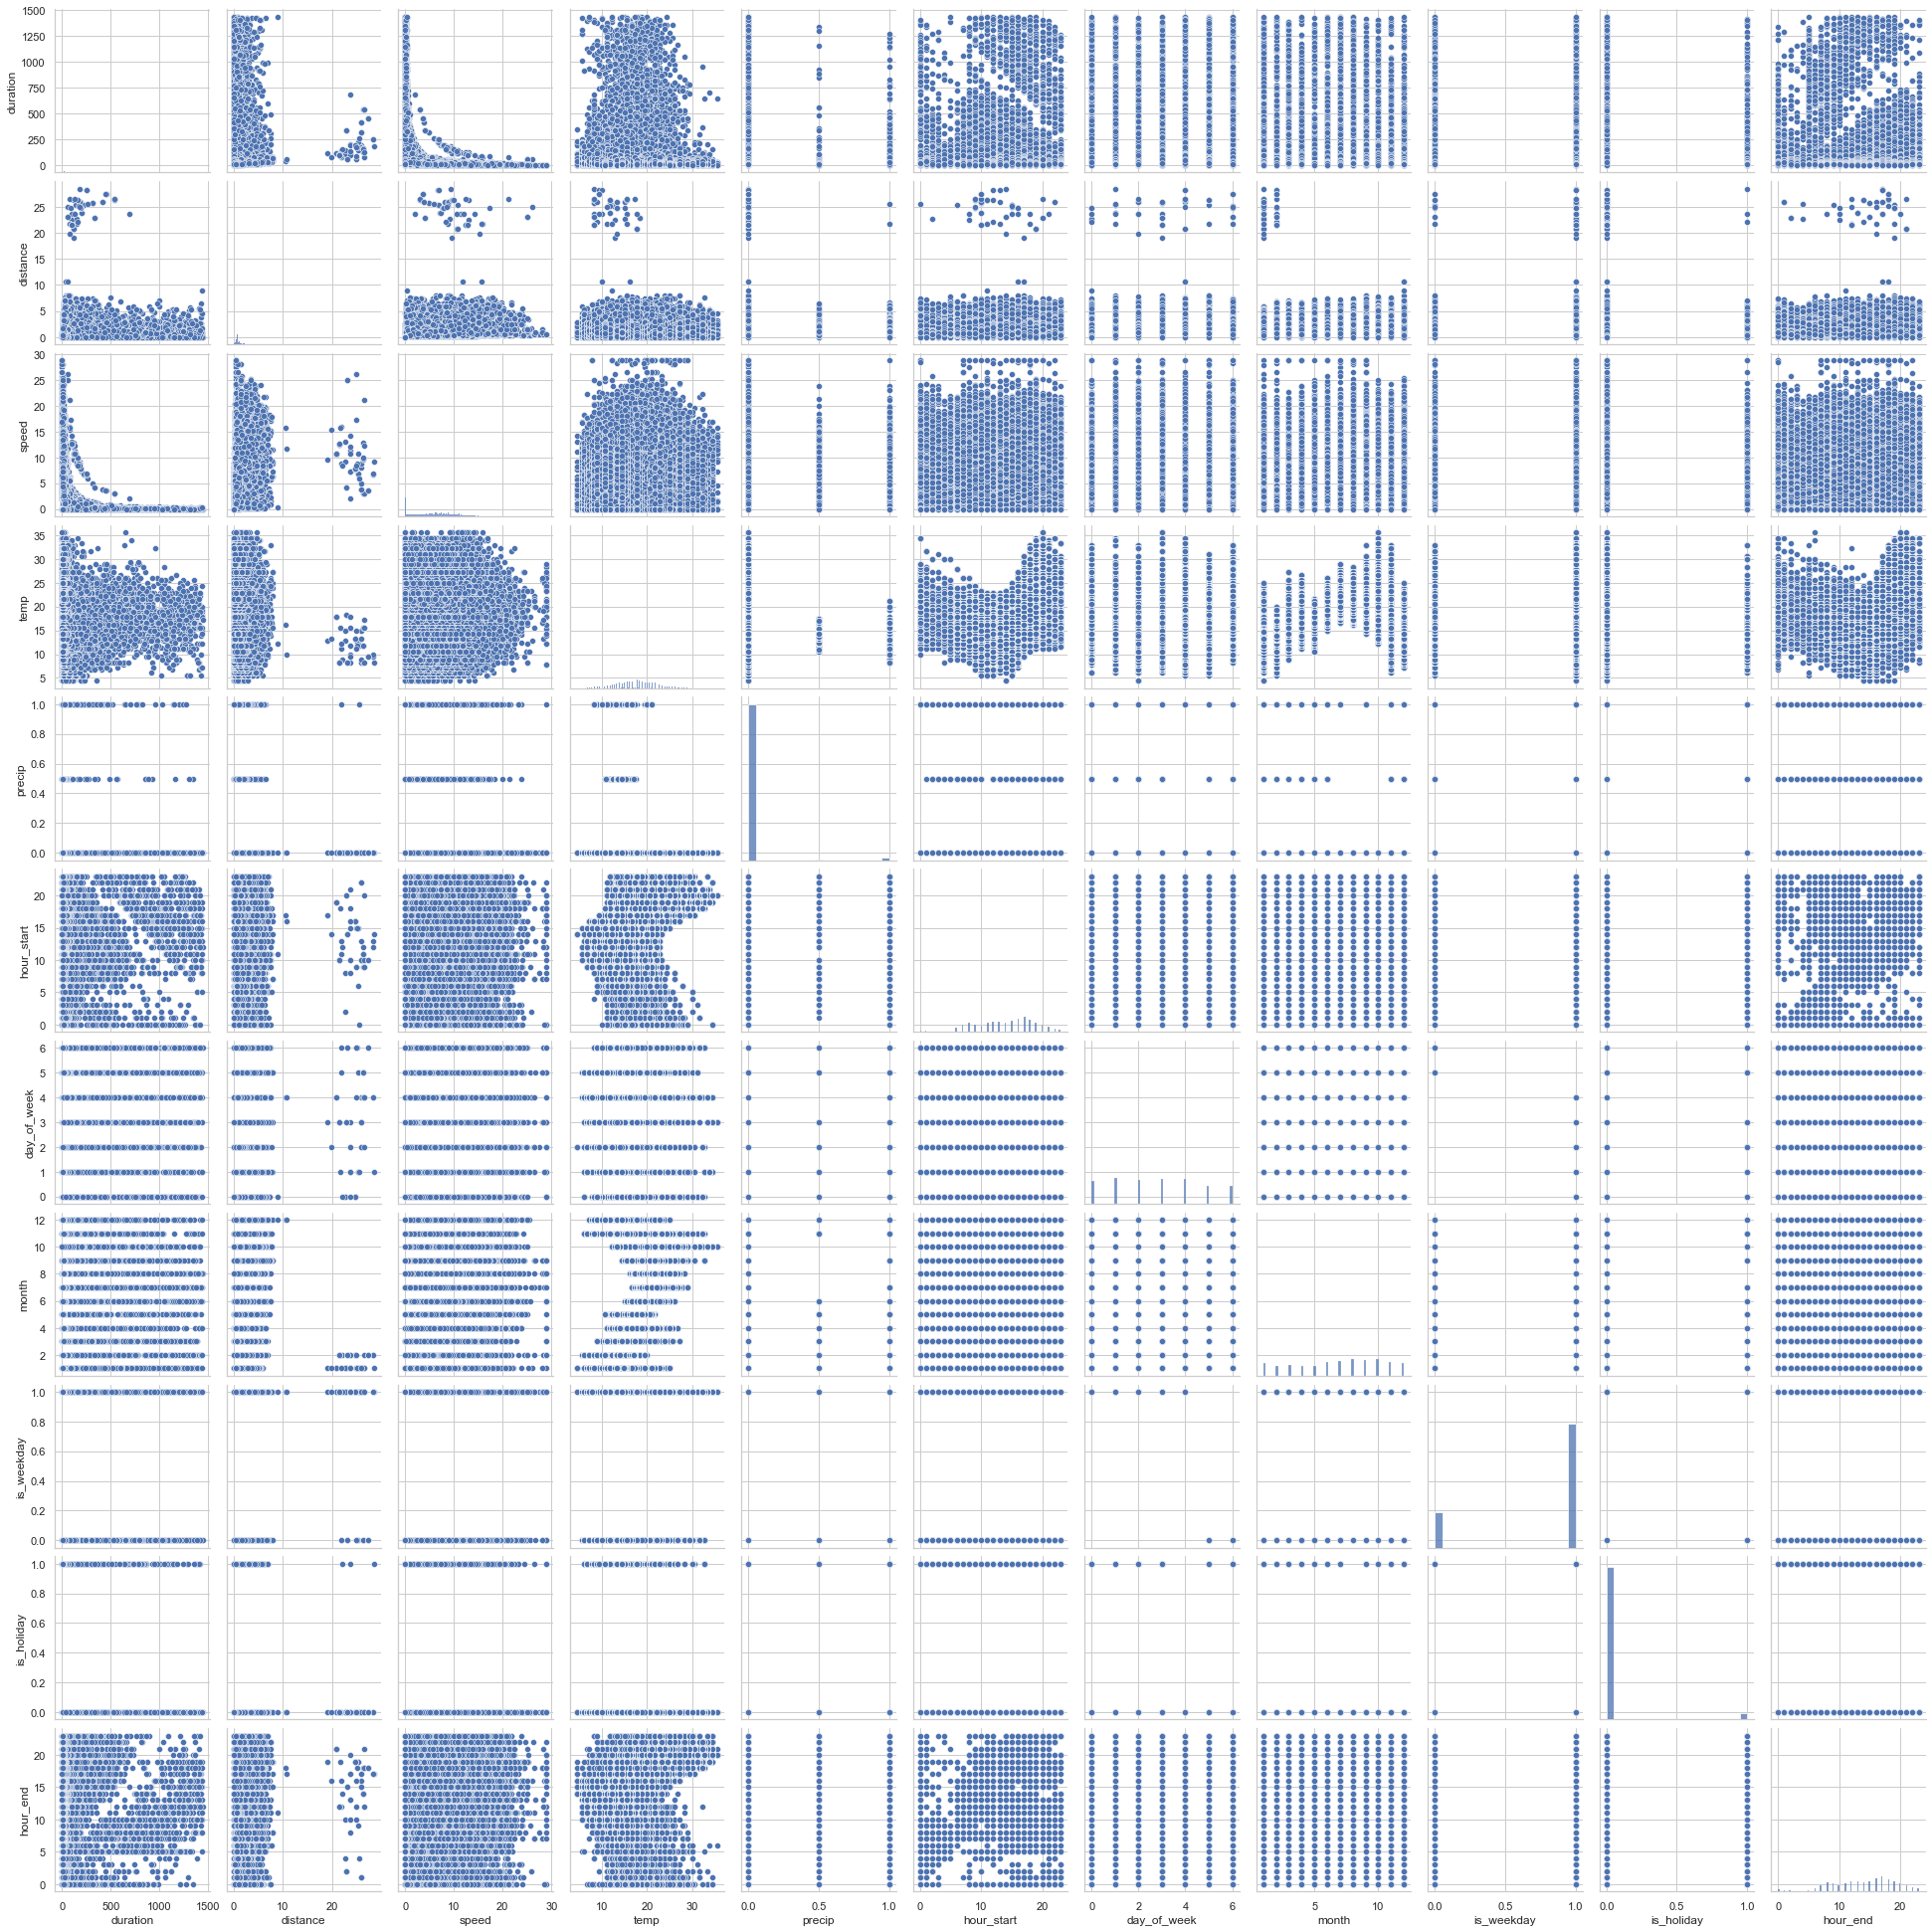

In [125]:
sns.pairplot(data=trips_df)

Looking at all plots we can recognize some groups that are distinguished:
 - Especially in the feature *distance* there is a clear cut between long and short trips.
 - In *duration* to *speed* we see a little cut between points in the middle and near the axes.
 - Between *duration* and both *hour_start* and *hour_end* there seems to be a linear cut through the data.
 - Comparing *speed* to other features we see some very fast bike riders in contrast to slower ones.

Let's scale our features so the distances we will compute are in the same Range.

In [126]:
X = trips_df
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head(3)

,duration,distance,speed,temp,precip,hour_start,day_of_week,month,is_weekday,is_holiday,hour_end
19,0.795684,-1.050004,-1.426842,-0.453807,-0.148258,-2.662604,-0.934522,-1.754357,0.53487,4.778389,-2.446509
20,-0.245179,-0.893602,-0.888913,-0.453807,-0.148258,-2.662604,-0.934522,-1.754357,0.53487,4.778389,-2.648989
21,0.768293,-1.050004,-1.426842,-0.453807,-0.148258,-2.662604,-0.934522,-1.754357,0.53487,4.778389,-2.446509


Now we will run two clustering algorithms on this data (K-means++ and Hierarchical Clustering) to answer three main questions:
 1. Which clusters can be found by the algorithms?
 2. Are those clusters useful and informative in terms of our business values?
 3. Can our cluster assumptions made above be found in the clusters by the algorithms?



## Algorithm 1: K-means++


The first algorithm is K-means++. We can use the KMeans() Model because scikit learn automatically uses K-means++
when not indicating that you want to have the original K-means with randomly selected centers in the beginning.

In [127]:
# defining the maximum quantity of centers
k_max = 20

clusters = []
losses = []

# train each model and save losses
for k in range(k_max):
    model = KMeans(n_clusters=k + 1, )
    model.fit(X_scaled)
    clusters.append(k + 1)
    losses.append(model.inertia_)

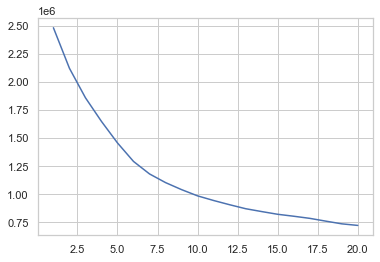

In [128]:
# plot losses
plt.plot(clusters, losses)
plt.show()

(0.0, 10.0)

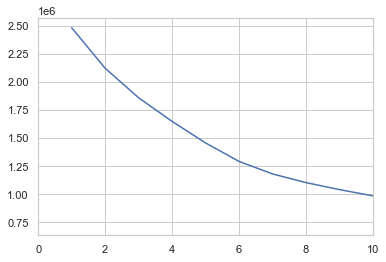

In [129]:
# plot losses more detailed
plt.plot(clusters, losses)
plt.xlim([0, 10])

In the more detailed plot the last "hard" edge is at k=7. This seems like a reasonable value for our cluster quantity so
 we will run the model with 7 clusters again and take a closer look. Furthermore we add a random state to our model so
 it can be recreated with the same cluster-label-numbers.

In [130]:
seven_means = KMeans(n_clusters=7, random_state=4711)
seven_means.fit(X_scaled)
seven_means.predict(X_scaled)


array([4, 4, 4, ..., 4, 4, 4], dtype=int32)

In [131]:
clusters = seven_means.cluster_centers_
clusters = scaler.inverse_transform(clusters)
clusters_df = pd.DataFrame(clusters, columns=X.columns)
clusters_rounded_df = clusters_df.round(2)
clusters_rounded_df["size"] = X_scaled_df.groupby(seven_means.labels_).size()
clusters_rounded_df.head()

,duration,distance,speed,temp,precip,hour_start,day_of_week,month,is_weekday,is_holiday,hour_end,size
0,18.19,0.92,5.71,13.28,-0.00,13.80,2.25,2.80,1.00,0.00,14.03,40111
1,12.55,1.11,7.44,17.36,0.00,8.64,2.14,8.30,0.96,-0.00,8.69,58251
2,18.00,0.95,5.91,13.88,0.92,14.78,2.38,4.87,0.83,0.09,15.03,4789
3,24.66,1.06,4.99,17.88,0.00,15.00,5.50,7.02,0.00,-0.00,15.23,45161
4,19.52,1.03,5.81,17.26,0.00,14.27,1.91,7.19,0.82,1.00,14.50,8972


Now we will analyse each cluster to label them.

In [132]:
X["cluster"] = seven_means.labels_

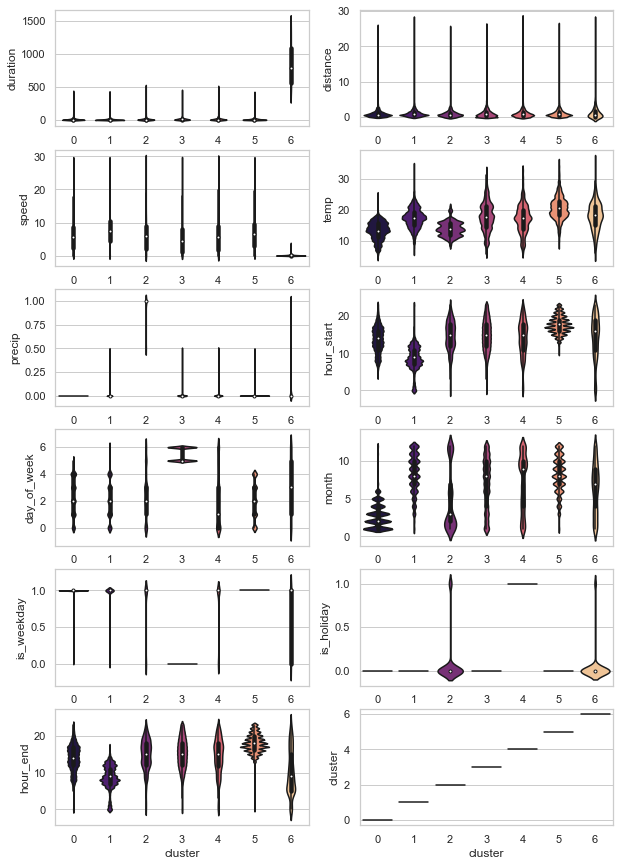

In [133]:
fig, axs = plt.subplots(6,2)
fig.set_size_inches(10,15)
plots_row = 0
plots_col = 0
for col in X.columns:
    sns.violinplot(x=X["cluster"], y=X[col], data=X, palette="magma",  ax=axs[plots_row][plots_col])
    if plots_col == 1:
        plots_row = plots_row + 1
        plots_col = 0
    else:
        plots_col = 1

In [134]:
# old labels
"""
clusters_rounded_df["labels"] = [
    "weekend",
    "fast|early|wednesday",
    "hot",
    "long",
    "rainy",
    "cold|sunny",
    "holiday",
]
"""


'\nclusters_rounded_df["labels"] = [\n    "weekend",\n    "fast|early|wednesday",\n    "hot",\n    "long",\n    "rainy",\n    "cold|sunny",\n    "holiday",\n]\n'

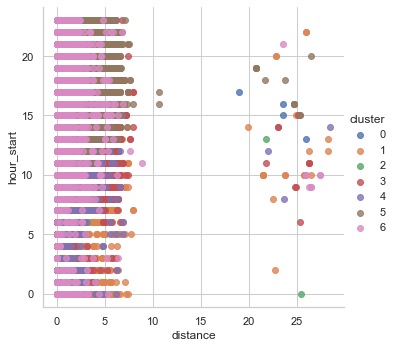

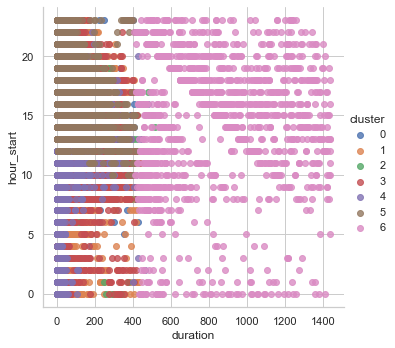

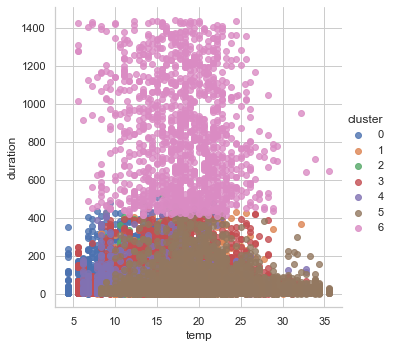

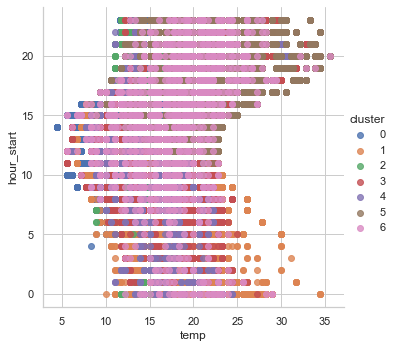

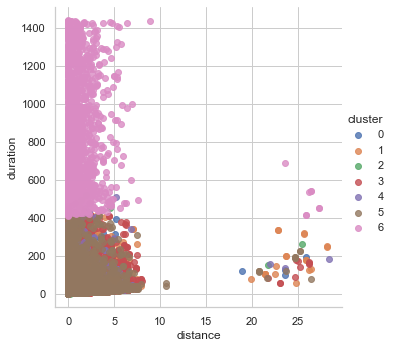

In [136]:
sns.lmplot(x="distance", y="hour_start", data=X, fit_reg=False, hue="cluster")
sns.lmplot(x="duration", y="hour_start", data=X, fit_reg=False, hue="cluster")
sns.lmplot(x="temp", y="duration", data=X, fit_reg=False, hue="cluster")
sns.lmplot(x="temp", y="hour_start", data=X, fit_reg=False, hue="cluster")
sns.lmplot(x="distance", y="duration", data=X, fit_reg=False, hue="cluster")


# with Principal Component Analysis (PCA) TODO?


In [18]:
# Scale features

scaler = StandardScaler()
trips_scaled = pd.DataFrame(scaler.fit_transform(trips_df))

In [19]:
trips_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.795684,-1.050004,-1.426842,-0.453807,-0.148258,-2.662604,-0.934522,-1.754357,0.53487,4.778389,-2.446509
1,-0.245179,-0.893602,-0.888913,-0.453807,-0.148258,-2.662604,-0.934522,-1.754357,0.53487,4.778389,-2.648989
2,0.768293,-1.050004,-1.426842,-0.453807,-0.148258,-2.662604,-0.934522,-1.754357,0.53487,4.778389,-2.446509
3,0.206775,1.981254,-0.299740,-0.453807,-0.148258,-2.662604,-0.934522,-1.754357,0.53487,4.778389,-2.446509
4,0.193079,1.981254,-0.268432,-0.453807,-0.148258,-2.662604,-0.934522,-1.754357,0.53487,4.778389,-2.446509


In [20]:
# Run PCA to reduce dimensionality
pca = PCA(n_components=4)
trips_scaled_pca = pca.fit_transform(trips_scaled)

In [21]:
sum(pca.explained_variance_ratio_)

0.6129716470828661

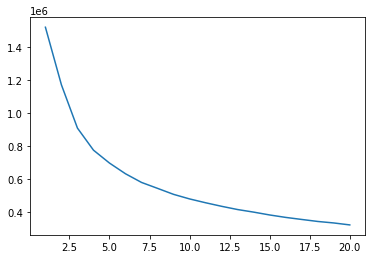

In [22]:
clusters = []
losses = []

for i in range(k_max):
    model = KMeans(n_clusters=i + 1)
    model.fit(trips_scaled_pca)
    clusters.append(i + 1)
    losses.append(model.inertia_)

plt.plot(clusters, losses)
plt.show()

(0.0, 10.0)

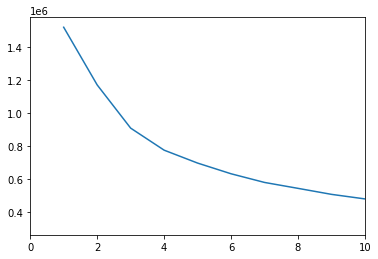

In [23]:
plt.plot(clusters, losses)
plt.xlim([0, 10])

In [24]:
best_kmeans = KMeans(n_clusters=4)
best_kmeans.fit(trips_scaled_pca)

KMeans(n_clusters=4)

In [25]:
best_kmeans.predict(trips_scaled_pca)

array([3, 3, 3, ..., 0, 0, 0], dtype=int32)

In [26]:
trips_scaled_pca_df = pd.DataFrame(trips_scaled_pca, index=trips_df.index)
trips_scaled_pca_df.columns = ["PC" + str(column + 1) for column in trips_scaled_pca_df.columns]

In [27]:
trips_scaled_pca_df["y"] = best_kmeans.predict(trips_scaled_pca)

trips_scaled_pca_df.head()

,PC1,PC2,PC3,PC4,y
19,3.354798,0.930508,-2.702986,-0.875422,3
20,3.636953,0.611940,-2.146833,-0.613034,3
21,3.355899,0.925625,-2.698408,-0.873488,3
22,3.853106,0.063284,-0.423807,0.742709,3
23,3.859796,0.051860,-0.405084,0.753694,3


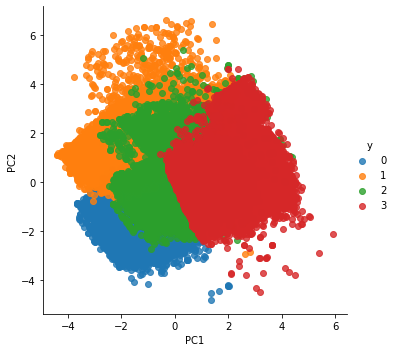

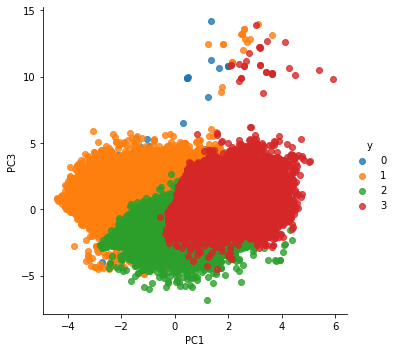

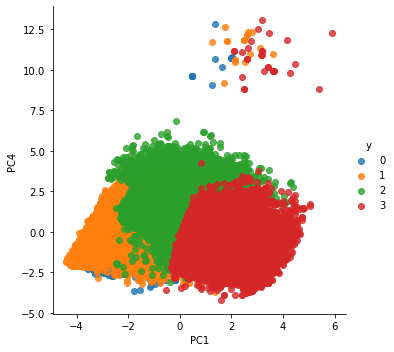

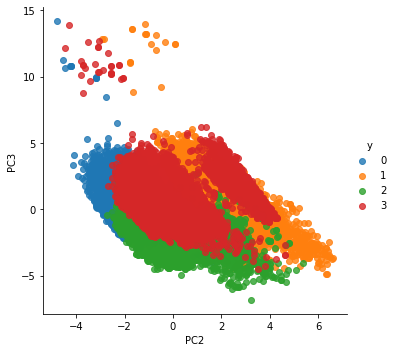

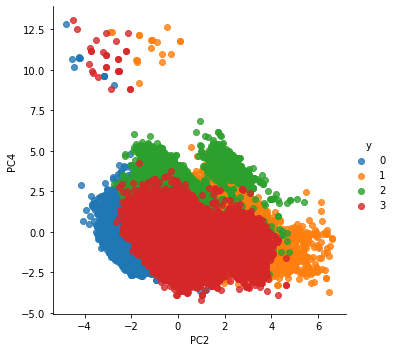

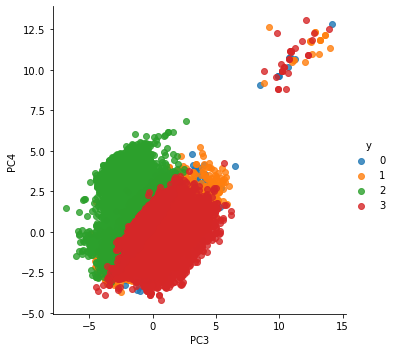

In [28]:
sns.lmplot(x="PC1", y="PC2", data=trips_scaled_pca_df, fit_reg=False, hue="y")
sns.lmplot(x="PC1", y="PC3", data=trips_scaled_pca_df, fit_reg=False, hue="y")
sns.lmplot(x="PC1", y="PC4", data=trips_scaled_pca_df, fit_reg=False, hue="y")
sns.lmplot(x="PC2", y="PC3", data=trips_scaled_pca_df, fit_reg=False, hue="y")
sns.lmplot(x="PC2", y="PC4", data=trips_scaled_pca_df, fit_reg=False, hue="y")
sns.lmplot(x="PC3", y="PC4", data=trips_scaled_pca_df, fit_reg=False, hue="y")

# Hierarchical Clustering

In [29]:
# Todo